https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import copy

from sklearn.metrics import normalized_mutual_info_score
from sklearn.covariance import MinCovDet
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
# file located at '/data' in parent directory
path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'creditcard.csv')) 
df = pd.read_csv(path)

In [3]:
df['Time_diff_from_previous'] = df['Time'].diff()
df['Time_diff_from_previous'].iloc[0] = 0
df['Time_diff_from_last'] = df['Time'].diff().iloc[1:].reset_index(drop=True)
df['Time_diff_from_last'].iloc[-1] = 0
display(df.head())
display(df.tail())

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_diff_from_previous,Time_diff_from_last
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,1.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.0,0.0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_diff_from_previous,Time_diff_from_last
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1.0,1.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1.0,1.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1.0,0.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0.0,4.0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0,4.0,0.0


In [4]:
df = df.drop('Time', 1)
df['Amount'] = df['Amount']/df['Amount'].max()

In [5]:
normal_data = df[df['Class']==0]
normal_data = normal_data.reset_index(drop=True)
display(normal_data.head())
print(normal_data.shape)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_diff_from_previous,Time_diff_from_last
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.005824,0,0.0,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.000105,0,0.0,1.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.014739,0,1.0,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.004807,0,0.0,1.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.002724,0,1.0,0.0


(284315, 32)


In [6]:
novel_data = df[df['Class']==1]
novel_data = novel_data.reset_index(drop=True)
display(novel_data.head())
print(novel_data.shape)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_diff_from_previous,Time_diff_from_last
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.000000,1,0.0,0.0
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,0.020591,1,0.0,0.0
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,0.009339,1,0.0,4.0
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,0.002297,1,0.0,1.0
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,0.000039,1,5.0,3.0


(492, 32)


In [7]:
dataX = df.copy().drop(['Class'],axis=1)
dataY = df['Class'].copy()

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, 
                                                    test_size=0.33, random_state=2018, stratify=dataY)

In [8]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [9]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds

In [10]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

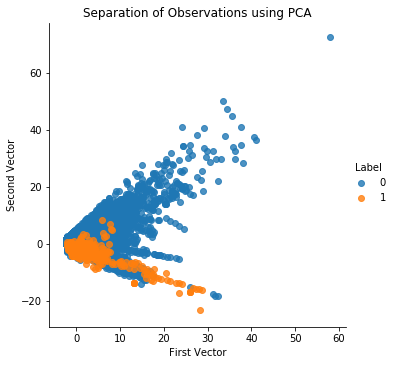

In [11]:
# 30 principal components
from sklearn.decomposition import PCA

n_components = 30
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

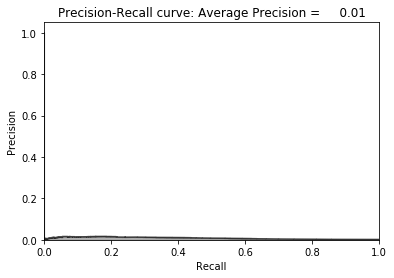

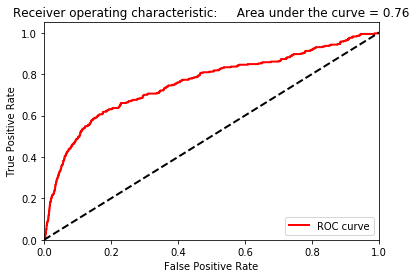

In [12]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [13]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.01
Recall:  0.01


C:\Anaconda3\lib\site-packages\sklearn\decomposition\sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


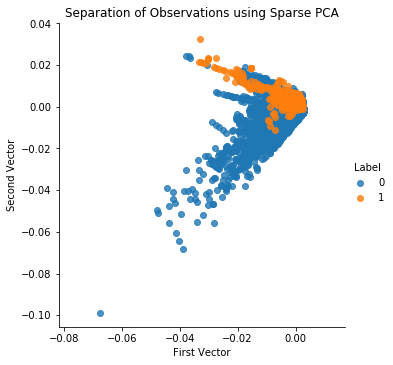

In [14]:
# Sparse PCA
from sklearn.decomposition import SparsePCA

n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, \
                alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

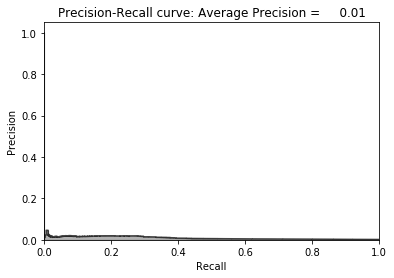

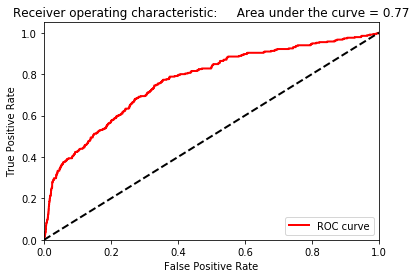

In [15]:
X_train_sparsePCA_inverse = np.array(X_train_sparsePCA). \
    dot(sparsePCA.components_) + np.array(X_train.mean(axis=0))
X_train_sparsePCA_inverse = \
    pd.DataFrame(data=X_train_sparsePCA_inverse, index=X_train.index)

anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

In [16]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.02
Recall:  0.02


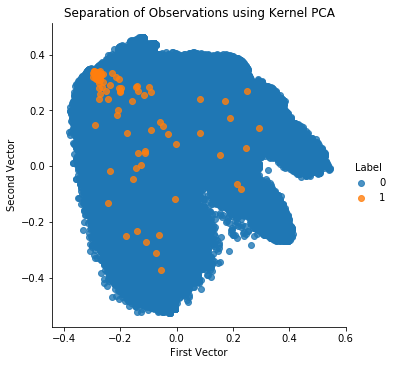

In [17]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 27
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)

kernelPCA.fit(X_train.iloc[:2000])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

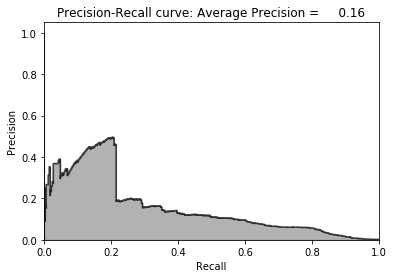

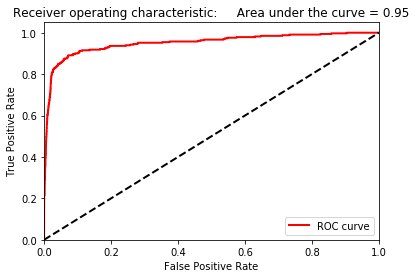

In [18]:
anomalyScoreskernelPCA = anomalyScores(X_train, X_train_kernelPCA_inverse)
preds = plotResults(y_train, anomalyScoreskernelPCA, True)

In [19]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.2
Recall:  0.22


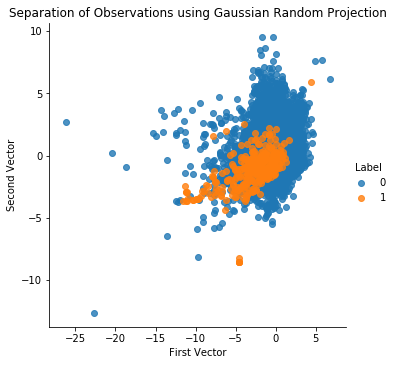

In [20]:
# Gaussian Random Projection
from sklearn.random_projection import GaussianRandomProjection

n_components = 27
eps = None
random_state = 2018

GRP = GaussianRandomProjection(n_components=n_components, \
                               eps=eps, random_state=random_state)

X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X_train.index)

scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

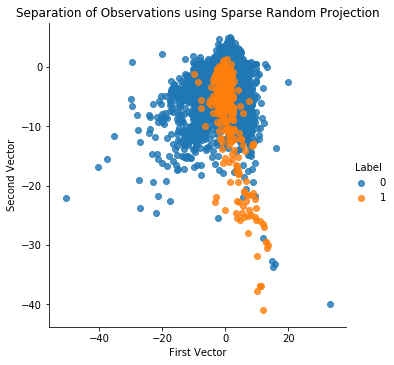

In [21]:
# Sparse Random Projection

from sklearn.random_projection import SparseRandomProjection

n_components = 27
density = 'auto'
eps = .01
dense_output = True
random_state = 2018

SRP = SparseRandomProjection(n_components=n_components, \
        density=density, eps=eps, dense_output=dense_output, \
                                random_state=random_state)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

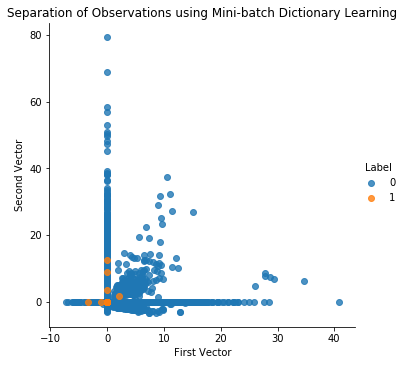

In [22]:
# Mini-batch dictionary learning
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 28
alpha = 1
batch_size = 200
n_iter = 10
random_state = 2018

miniBatchDictLearning = MiniBatchDictionaryLearning( \
    n_components=n_components, alpha=alpha, batch_size=batch_size, \
    n_iter=n_iter, random_state=random_state)

miniBatchDictLearning.fit(X_train)
X_train_miniBatchDictLearning = \
    miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = \
    pd.DataFrame(data=X_train_miniBatchDictLearning, index=X_train.index)

scatterPlot(X_train_miniBatchDictLearning, y_train, \
            "Mini-batch Dictionary Learning")

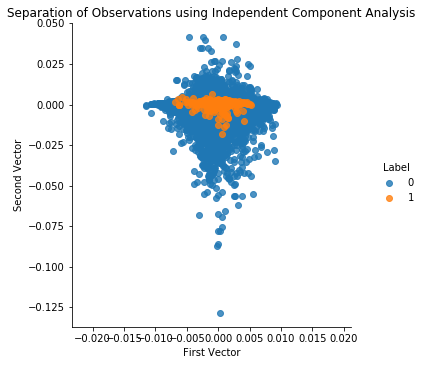

In [23]:
# Independent Component Analysis

from sklearn.decomposition import FastICA

n_components = 27
algorithm = 'parallel'
whiten = True
max_iter = 200
random_state = 2018

fastICA = FastICA(n_components=n_components, \
    algorithm=algorithm, whiten=whiten, max_iter=max_iter, \
    random_state=random_state)

X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=X_train.index)

X_train_fastICA_inverse = fastICA.inverse_transform(X_train_fastICA)
X_train_fastICA_inverse = pd.DataFrame(data=X_train_fastICA_inverse, \
                                       index=X_train.index)

scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")

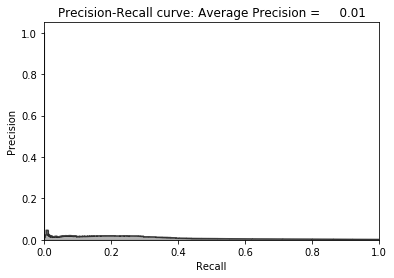

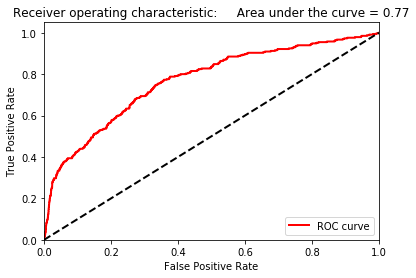

In [24]:
anomalyScoresfastICA = anomalyScores(X_train, X_train_fastICA_inverse)
preds = plotResults(y_train, anomalyScoresfastICA, True)

In [25]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.02
Recall:  0.02


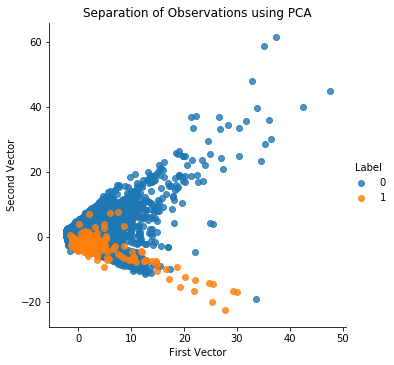

In [26]:
# PCA on Test Set
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, \
                                  index=X_test.index)

scatterPlot(X_test_PCA, y_test, "PCA")

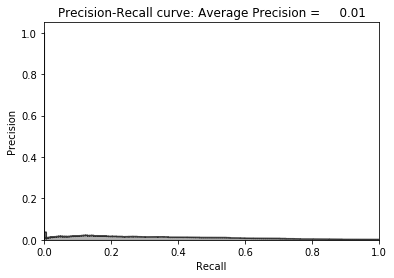

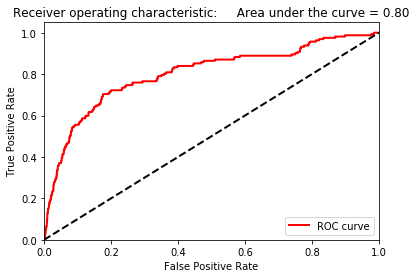

In [27]:
anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomalyScoresPCA, True)

In [28]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.01
Recall:  0.02


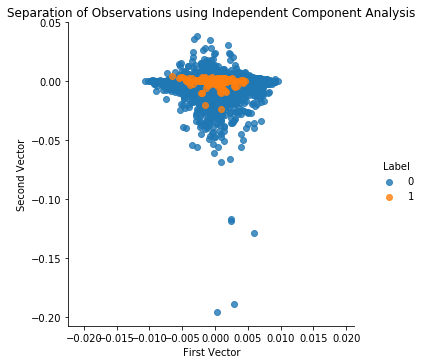

In [29]:
# Independent Component Analysis on Test Set
X_test_fastICA = fastICA.transform(X_test)
X_test_fastICA = pd.DataFrame(data=X_test_fastICA, index=X_test.index)

X_test_fastICA_inverse = fastICA.inverse_transform(X_test_fastICA)
X_test_fastICA_inverse = pd.DataFrame(data=X_test_fastICA_inverse, \
                                      index=X_test.index)

scatterPlot(X_test_fastICA, y_test, "Independent Component Analysis")

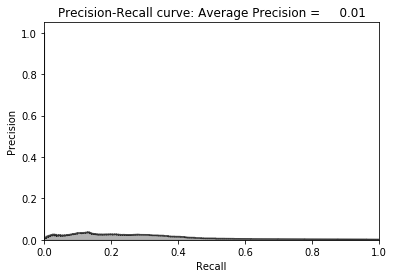

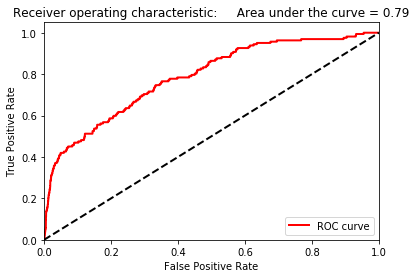

In [30]:
anomalyScoresfastICA = anomalyScores(X_test, X_test_fastICA_inverse)
preds = plotResults(y_test, anomalyScoresfastICA, True)

In [31]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.02
Recall:  0.02


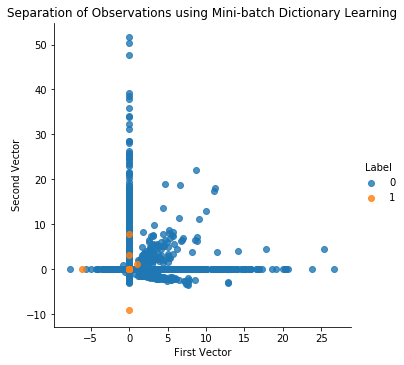

In [32]:
# Mini-batch Dictionary Learning
X_test_miniBatchDictLearning = miniBatchDictLearning.transform(X_test)
X_test_miniBatchDictLearning = \
    pd.DataFrame(data=X_test_miniBatchDictLearning, index=X_test.index)

scatterPlot(X_test_miniBatchDictLearning, y_test, \
            "Mini-batch Dictionary Learning")